# <h1><center>TP2 - Visión por computadora - CEIA</center></h1>

In [24]:
# Importaciones
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple, Union
from enum import Enum
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

<center>

<img src="./resources/portada.jpeg" width="600" alt="Figura 1: A person applying a sharpness filter, in the spectral domain, on an image inside a computer. The person is a scientist expert in computer vision - Generada con Microsoft Image Creator">

<small><em>Figura 1: A person applying a sharpness filter, in the spectral domain, on an image inside a computer. The person is a scientist expert in computer vision - Generada con Microsoft Image Creator</em></small>

</center>

<center>
<p>✨Datos del proyecto:✨<p>

| Subtitulo       | TP2 - Visión por computadora - FIUBA                                                                                                   |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Análisis de enfoque en el dominio espectral                                                                                            |
| **Integrantes** | - Bruno Masoller (brunomaso1@gmail.com) </br>- Simón Rodriguez (simon.andre.r@gmail.com)                                               |

</center>

## Consinga

![Consinga](.\resources\Consigna.PNG)

![Ejemplo](.\resources\Ejemplo1.PNG)

## Parte 1

> Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las  cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

> Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
> 1. Medición sobre todo el frame.
> 2. Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.
> 3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3)
 
> Para cada experimento se debe presentar :
> - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
> - Video con la ROI o matriz,  graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

*Funciones auxiliares y configuraciones:*

🔧 <em><font color='tomato'><strong>Configuraciones:</strong></font></em>

In [25]:
# Definimos constantes a utilizar
COLOR_GREEN = (0, 255, 0)
COLOR_RED = (0, 0, 255)

# Tamaño de la caja en la matriz de enfoque
BOX_SIZE = 20

# Tamaño de la linea que rodea los boxes
BOX_LINE_WIDTH = 2

# Focus Metric Thresshold -> Es el valor límite sobre el cual se considera que el video está enfocado
FM_TRHESHOLD = 0.04

VIDEO_PATH = './resources/focus_video.mov'
IMG_TEST_PATH = './resources/segmentacion.png'

In [26]:
# Definimos los tipos de experimentos
class ExperimentTypes(Enum):
    ALL_IMAGE = 'all_image'
    ROI = 'roi'
    FOCUS_MATRIX = 'focus_matrix'

*Métrica del paper: __Image Sharpness Measure for Blurred Images in Frequency Domain__*

*Como resumen, el algorimto que se propone es el siguiente:*

<em><p>
- Input: Image I of size MxN
- Output: Image Quality measure (FM) where FM stands for Frequency Domain Image Blur Measure 
- Step 1: Compute F which is the Fourier Transform representation of image I   
- Step 2: Find Fc which is obtained by shifting the origin of F to centre.
- Step 3: Calculate AF = abs(Fc) where AF is the absolute value of the centered Fourier transform of image I. 
- Step 4: Calculate M = max(AF) where M is the maximum value of the frequency component in F. 
- Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000. 
- Step 6: Calculate Image Quality measure (FM) from equation: Image Quality Measure (FM) = THp
</p></em>

In [27]:
def kanjar_fm(image_rgb: np.ndarray) -> float:
    # Pasamos la imagen a negro
    img = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    
    # Hacemos la transformada y centramos con estas lineas mágicas.
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    
    # Obtenemos los valores absolutos de todos los coeficientes.
    abs_values = np.abs(img_fft)
    
    # Obtenemos el máximo de los coeficientes.
    maximum_value = np.max(abs_values)
    
    # Calculamos los pixeles totales que fueron mayores al threeshold maximun_value/1000
    T_H = abs_values[abs_values > (maximum_value / 1000)].size
    
    # Finalmente retornamos la métrica    
    return T_H/img.size

*Probamos la métrica de la siguiente forma, primero tomamos una imagen que está enfocada y luego le aplciamos un desenfoque gaussiano a la misma. Finalmente, calculamos la métrica para ámbas imágenes. Lo lógico sería que la que está enfocada tenga mayor valor que la que está des-enfocada:*

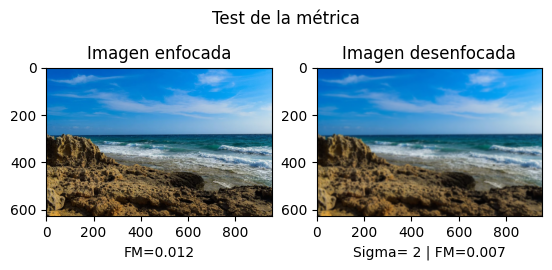

In [28]:
img = cv.imread(IMG_TEST_PATH)

plt.suptitle('Test de la métrica')

plt.subplot(221)
plt.imshow(img[:, :, ::-1])
plt.xlabel(f'FM={kanjar_fm(img):.3f}')
plt.title('Imagen enfocada')

sigma = 2
plt.subplot(222)
plt.imshow(cv.GaussianBlur(img, (15, 15), sigma)[:, :, ::-1])
plt.xlabel(f'Sigma= {sigma} | FM={kanjar_fm(cv.GaussianBlur(img, (15, 15), sigma)):.3f}')
plt.title('Imagen desenfocada')

plt.show()

🔮 <em><font color='violet'><strong>Función auxiliar:</strong> Convierte una figura en una imagen RGB.</font></em>

In [29]:
def convert_fig_to_img(fms: np.ndarray, colors: np.ndarray, frame_width: int, frame_height: int) -> np.ndarray:
    """Convierte una figura (scatterplot) en una imagen BGR

    Args:
        fms (np.ndarray): Valores de la función a graficar
        colors (np.ndarray): Colores a graficar
        frame_width (int): Ancho de la imagen
        frame_height (int): Alto de la imagen

    Returns:
        np.ndarray: Una imagen RGB
    """
    
    fig, ax = plt.subplots()

    # Creamos el scatter, donde x son los índices e y los valores de fms
    ax.scatter(range(len(fms)), fms, c=colors)

    # Crea un objeto `FigureCanvas` a partir de la figura `fig`.
    canvas = FigureCanvas(fig)

    # Dibuja la figura en el canvas para que se renderice.
    canvas.draw()

    # Convierte el contenido del canvas a un arreglo de NumPy usando el buffer RGBA.
    # Queda un np.ndarray de una dimensión (una lista)
    graph_image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')

    # Redimensiona el arreglo de NumPy a las dimensiones correctas.
    # canvas.get_width_height() devuelve (ancho, alto)
    # [::-1], lo inverte a (alto, ancho)
    # Luego se agregan los canales faltantes (Rojo, Verde, Azul, Alpha) con + (4,)
    graph_image = graph_image.reshape(canvas.get_width_height()[::-1] + (4,))  # Queda (H, W, 4)

    # Convierte la imagen de formato RGBA a formato BGR, que es el formato de color esperado por OpenCV.
    graph_image = cv.cvtColor(graph_image, cv.COLOR_RGBA2BGR)

    # Redimensiona la imagen del gráfico para que coincida con el tamaño del frame del video.
    graph_image = cv.resize(graph_image, (frame_width, frame_height))
    
    # Hay que cerrar la figura sino hay memory leak
    plt.close(fig)

    return graph_image

🔮 <em><font color='violet'><strong>Función auxiliar:</strong> Calcula el bbox para toda una imagen.</font></em>

In [30]:
def get_all_image_bbox(frame: np.ndarray) -> Union[Tuple, Tuple]:
    frame_height, frame_width, _ = frame.shape

    # Simplemente devuelvo toda la imagen, pero con un espacio de 1 por el tamaño de la linea de la bbox.
    return (1, 1), (frame_width-1, frame_height-1)

🔮 <em><font color='violet'><strong>Función auxiliar:</strong> Calcula una región de interes (o sea, devuelve una imagen basada en dicha región de interés desde el centro).</font></em>

In [31]:
def get_roi_bbox(frame: np.ndarray, roi: int) -> Union[np.ndarray, Tuple]:
    frame_height, frame_width, _ = frame.shape

    # Obtengo la cantidad de pixeles que ocupa la ROI
    roi_width = int(frame_width * roi/100)
    roi_height = int(frame_height * roi/100)
    # Obtengo el centro de la imagen
    center_x, center_y = frame_width // 2, frame_height // 2

    # Obtengo el comienzo de la ROI
    x = center_x - (roi_width // 2)
    y = center_y - (roi_height // 2)

    # Corto la imagen por el tamaño de la bbox
    roi_frame = frame[y:y + roi_height, x:x + roi_width]

    bbox_start = (x, y)
    bbox_end = (x + roi_width, y + roi_height)
    
    return roi_frame, (bbox_start, bbox_end)


🔮 <em><font color='violet'><strong>Función auxiliar:</strong> Calcula la matriz de enfoque.</font></em>

In [32]:
def get_focus_matrix_bbox(frame: np.ndarray, focus_matrix: Tuple) -> Tuple:
    image_sub_list = []
    bbox_sub_list = []
    frame_height, frame_width, _ = frame.shape

    N, M = focus_matrix

    # Asigno el tamaño de la caja de la matriz de enfoque
    cell_width = cell_height = BOX_SIZE
    # Espacio entre boxes
    cell_spacing = BOX_SIZE // 2

    center_x, center_y = frame_width // 2, frame_height // 2

    # El comienzo es el punto superior más a la izquierda.
    # De ahi empiezo a iterar, mediante el espacio por cada celda.
    # Lo que hago es restar el tamaño al frame por coordenada y luego lo centro.
    start_x = (frame_width - (cell_width * N + (N - 1) * cell_spacing)) // 2
    start_y = (frame_height - (cell_height * M + (M - 1) * cell_spacing)) // 2

    # Prepara arrays para las coordenadas
    # O sea, voy a tener un array con los puntos de inicio de la bounding box
    # Luego solo hay que recorrer ambas listas y armar las bbox.
    x_coords = start_x + np.arange(N) * (cell_width + cell_spacing)
    y_coords = start_y + np.arange(M) * (cell_height + cell_spacing)

    image_sub_list = []
    bbox_sub_list = []
    for x in x_coords:
        for y in y_coords:
            cell_frame = frame[y:y+cell_height, x:x+cell_width]
            image_sub_list.append(cell_frame)
            bbox_sub_list.append(((x, y), (x + cell_width, y + cell_height)))

    return image_sub_list, bbox_sub_list

🔮 <em><font color='violet'><strong>Función auxiliar:</strong> Realiza una gráfica simple.</font></em>

In [23]:
def plot_fms(fms: np.ndarray, fm_threshold=None, title: str = 'Grafica FM', xlabel: str = 'Frames', ylabel: str = 'FM') -> None:
    plt.figure()
    plt.plot(fms)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if fm_threshold: plt.axhline(y=fm_threshold, c='g')
    plt.show()

*Se plantea realizar una fución genérica que realiza los experimentos. Dependiendo de cual experimento, es la región a calcular:*

In [33]:
def do_eperiment(video_path: str, function_metric: Callable, experiment_type: ExperimentTypes = ExperimentTypes.ALL_IMAGE, threshold: float = 0.04,  roi: np.ndarray = None, focus_matrix: Tuple[int, int] = None, box_size: int = 20, background=False) -> List[np.ndarray]:
    captura_video = cv.VideoCapture(video_path)

    fms = []
    colors = []

    if not captura_video.isOpened():
        raise IOError("Error al abrir el archivo de video")
    else:
        # Obtener las dimensiones del video
        frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
        frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))

        # Obtén la tasa de cuadros (frame rate) del video
        fps = int(captura_video.get(cv.CAP_PROP_FPS))
        delay = int(1000 / fps)

        while True:
            ret, frame = captura_video.read()
            if not ret:
                break

            image_list = []
            bbox_list = []

            match experiment_type:
                case ExperimentTypes.ALL_IMAGE:
                    bbox_start, bbox_end = get_all_image_bbox(frame)

                    image_list.append(frame)
                    bbox_list.append((bbox_start, bbox_end))
                case ExperimentTypes.ROI:
                    if not roi:
                        raise ValueError(f'roi no puede ser None para el experimento {
                                         experiment_type}')

                    roi_frame, (bbox_start, bbox_end) = get_roi_bbox(
                        frame, roi)

                    image_list.append(roi_frame)
                    bbox_list.append((bbox_start, bbox_end))

                case ExperimentTypes.FOCUS_MATRIX:
                    if not focus_matrix:
                        raise ValueError(f'sharpness_matrix no puede ser None para el experimento {
                                         experiment_type}')

                    image_list, bbox_list = get_focus_matrix_bbox(
                        frame, focus_matrix)

                case _:
                    raise ValueError(f'Experimento no definido: {
                                     experiment_type}')

            # Se hace un ciclo for por el caso de que el experimento sea un SPARSE_MATRIX
            # En este caso se calcula el valor medio de todas las imágenes.
            # Si no es este tipo, no pasa nada porque el contenido de la lista es 1
            fm = np.mean([function_metric(image) for image in image_list])

            # Determina el color basado en el threshold.
            color = 'g' if fm >= threshold else 'r'
            cv_color = COLOR_GREEN if fm >= threshold else COLOR_RED

            # Agregamos a las listas los valores de la métrica y el color
            fms.append(fm)
            colors.append(color)

            if not background:
                # Dibujamos las cajas
                for bbox_start, bbox_end in bbox_list:
                    cv.rectangle(frame, bbox_start, bbox_end, cv_color, 2)

                # Convierto la figura (gráfica) a imagen para poner una al lado de la otra
                graph_image = convert_fig_to_img(
                    fms, colors, frame_width, frame_height)

                # Combina el frame original y la imagen del gráfico lado a lado
                frame_combined = np.hstack((frame, graph_image))

                # Mostrar el frame combinado
                cv.imshow('Video Enfocado', frame_combined)

                # Salir del loop si se presiona la tecla 'q'
                if cv.waitKey(delay) & 0xFF == ord('q'):
                    break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv.destroyAllWindows()

    return fms, colors

### Experimento 1

*Realizamos el experimento:*

In [34]:
FM_TRHESHOLD = 0.04
fms, _ = do_eperiment(
    VIDEO_PATH, kanjar_fm, experiment_type=ExperimentTypes.ALL_IMAGE, threshold=FM_TRHESHOLD, background=False)

*Graficamos los valores de la métrica:*

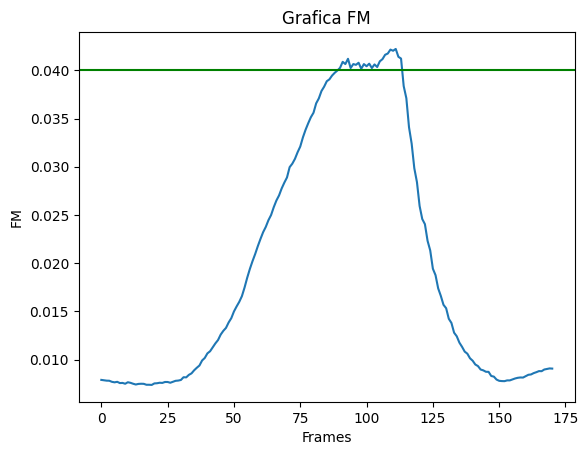

In [35]:
plot_fms(fms, FM_TRHESHOLD)

### Experimento 2

*Realizamos el experimento:*

In [ ]:
FM_TRHESHOLD = 0.04 # Mismo que el caso anterior
roi = 10
fms, _ = do_eperiment(
    VIDEO_PATH, kanjar_fm, experiment_type=ExperimentTypes.ROI, threshold=FM_TRHESHOLD, roi=roi, background=False)

*Graficamos los valores de la métrica:*

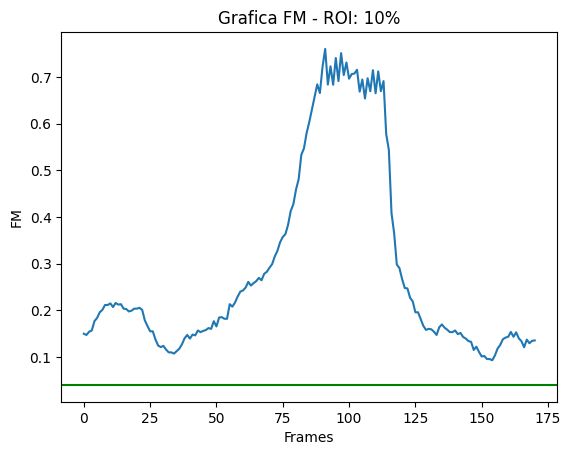

In [ ]:
plot_fms(fms, FM_TRHESHOLD, title=f'Grafica FM - ROI: {roi}%')

⭐**Conclusión**⭐

*En este punto, podemos ver que hay que cambiar el valor de la métrica, dado que todos los valores dieron superior al anteriormente pactado.*

*Si hacemos el experimento con un umbral diferente, por ejemplo, 0.6 podemos ver que funciona correctamente:*

In [ ]:
FM_TRHESHOLD = 0.6
roi = 10
fms, _ = do_eperiment(
    VIDEO_PATH, kanjar_fm, experiment_type=ExperimentTypes.ROI, threshold=FM_TRHESHOLD, roi=roi, background=False)

*Graficamos los valores de la métrica:*

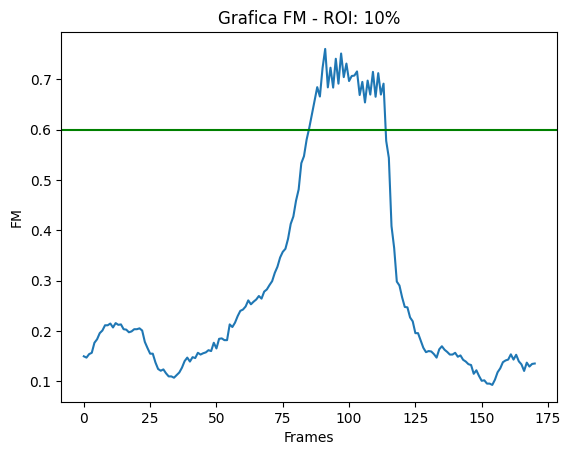

In [ ]:
plot_fms(fms, FM_TRHESHOLD, title=f'Grafica FM - ROI: {roi}%')

### Experimento 3

*Matriz de 7x7*

In [ ]:
focus_matrix = (7,7)
FM_TRHESHOLD = 0.04
fms, _ = do_eperiment(
    VIDEO_PATH, kanjar_fm, experiment_type=ExperimentTypes.FOCUS_MATRIX, focus_matrix=focus_matrix, threshold=FM_TRHESHOLD, background=False)

*Graficamos los valores de la métrica:*

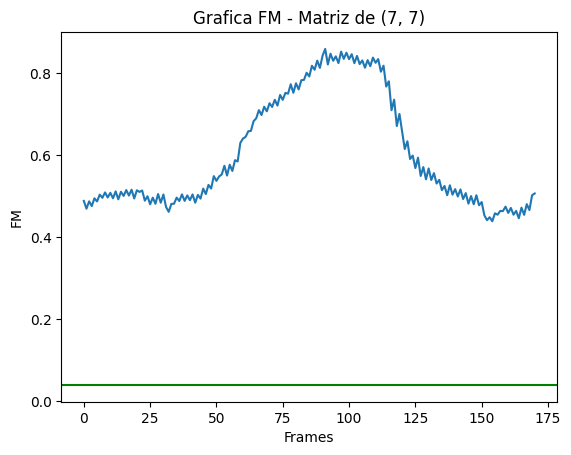

In [ ]:
plot_fms(fms, FM_TRHESHOLD, title=f'Grafica FM - Matriz de {focus_matrix}')

*Pasa lo mismo que en el caso anterior, por lo que ajustamos la métrica:*

*Matriz de 9x9*

In [ ]:
focus_matrix = (9, 9)
FM_TRHESHOLD = 0.65
fms, _ = do_eperiment(
    VIDEO_PATH, kanjar_fm, experiment_type=ExperimentTypes.FOCUS_MATRIX, focus_matrix=focus_matrix, threshold=FM_TRHESHOLD, background=False)

*Graficamos los valores de la métrica:*

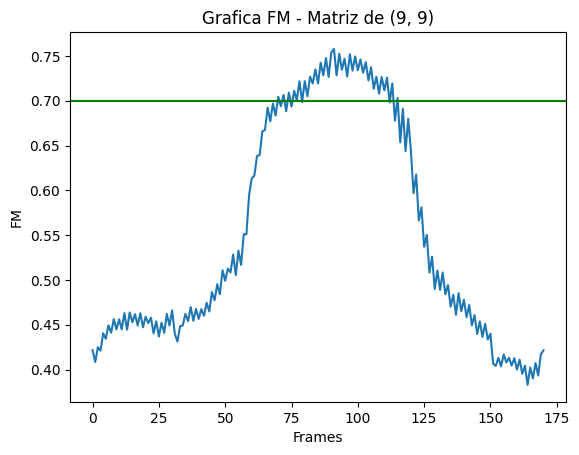

In [ ]:
plot_fms(fms, FM_TRHESHOLD, title=f'Grafica FM - Matriz de {focus_matrix}')

## Parte 2

> Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analisis of focus measure operators in shapeform focus.

*La métrica elegida para esta parte es la nombrada en el paper como LAP4 (Varianza del laplaciano). Dado que el filtro del Laplaciano es un detector de bordes, si hacemos la convolución con la imagen, desde el punto de vista de bordes, una imágen más enfocada tendría más que una menos enfocada. Haciendo que la varianza sea máxima podríamos decir si ésta está enfocada o no. El problema de estet filtro es que es sensible al ruido, pero la ventaja que OpenCV ya lo tiene implemnetado. Es aplicarlo y simplemente obtener la varianza.*

In [ ]:
def lap4_fm(image: np.ndarray) -> float:
    # Pasamos la imagen a negro
    img = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    
    # Finalmente, simplemente retornamos la variación que hay luego de aplicarle
    # el filtro laplaciano a la imagen
    return cv.Laplacian(img, cv.CV_64F).var()

*Probamos la métrica con una imagen:*

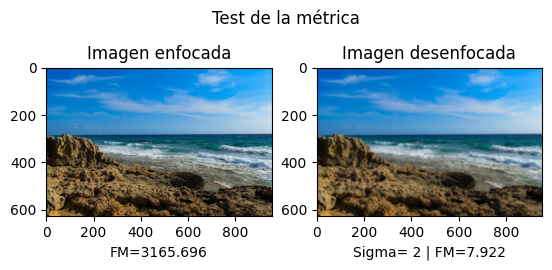

In [ ]:
img = cv.imread(IMG_TEST_PATH)

plt.suptitle('Test de la métrica')

plt.subplot(221)
plt.imshow(img[:, :, ::-1])
plt.xlabel(f'FM={lap4_fm(img):.3f}')
plt.title('Imagen enfocada')

sigma = 2
plt.subplot(222)
plt.imshow(cv.GaussianBlur(img, (15, 15), sigma)[:, :, ::-1])
plt.xlabel(f'Sigma= {sigma} | FM={lap4_fm(cv.GaussianBlur(img, (15, 15), sigma)):.3f}')
plt.title('Imagen desenfocada')

plt.show()

*Podemos observar que la que mayor valor tiene de la métrica, es la que más enfocada está.*

### Experimento 1

*Nuevamente tenemos que ajustar el límite dependiendo de la imagen*

In [ ]:
FM_TRHESHOLD = 80
fms, _ = do_eperiment(
    VIDEO_PATH, lap4_fm, experiment_type=ExperimentTypes.ALL_IMAGE, threshold=FM_TRHESHOLD, background=True)

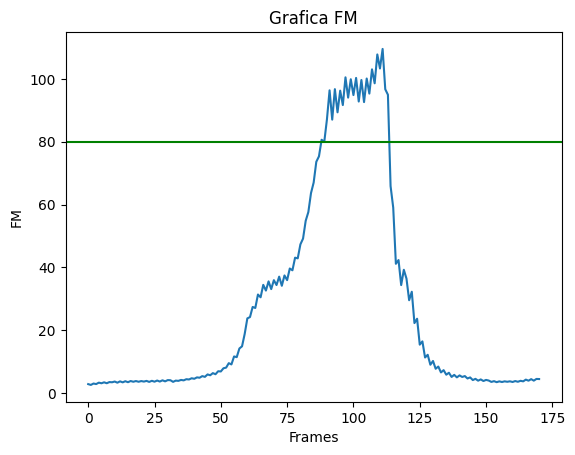

In [ ]:
plot_fms(fms, FM_TRHESHOLD)

### Experimento 2

In [ ]:
FM_TRHESHOLD = 250
roi=50
fms, _ = do_eperiment(
    VIDEO_PATH, lap4_fm, experiment_type=ExperimentTypes.ROI, roi=roi, threshold=FM_TRHESHOLD, background=True)

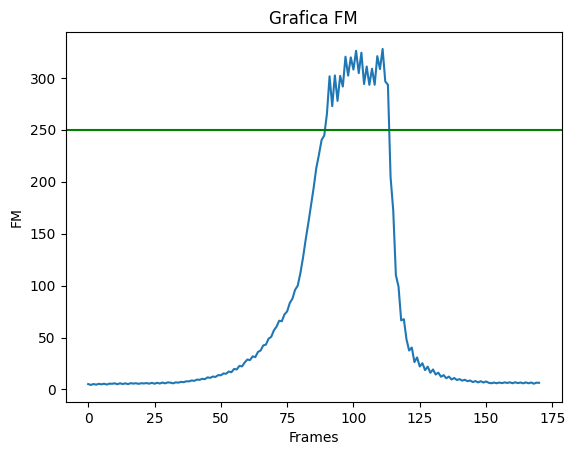

In [ ]:
plot_fms(fms, FM_TRHESHOLD)

### Experimento 3

In [ ]:
FM_TRHESHOLD = 280
focus_matrix = (7, 7)
fms, _ = do_eperiment(
    VIDEO_PATH, lap4_fm, experiment_type=ExperimentTypes.FOCUS_MATRIX, focus_matrix=focus_matrix, threshold=FM_TRHESHOLD, background=True)

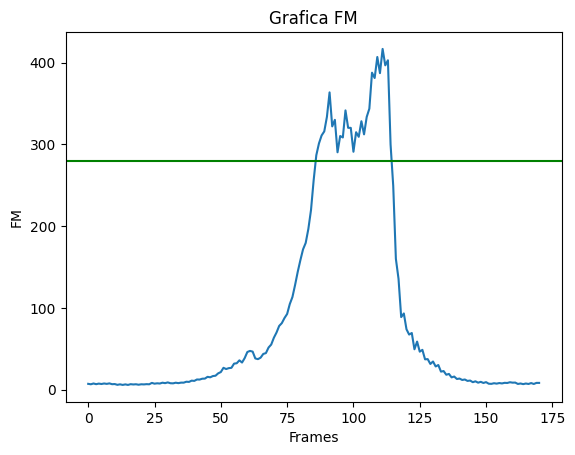

In [ ]:
plot_fms(fms, FM_TRHESHOLD)

## Unsharp masking

In [ ]:
#TODO

## Enfoque adaptativo

*Para resolver el problema de estar buscando el umbral ideal del enfoque, se plantea, según el análisis previo, que la mayoría de los casos hay un pico en donde está el enfoque. Como hipótesis, si se pudiera predecir este pico, se podría lograr enfocar sin depender de un umbral.*

*Para esto, se decide utilizar el algoritmo Robust peak detection algorithm (using z-scores), para detectar estos picos y por defecto, detectar el enfoque.*

🔮 <em><font color='violet'><strong>Función auxiliar:</strong> real_time_peak_detection, permite calcular los altos y bajos de una señal, de forma adaptativa (cuasi-magia)</font></em>

<small>https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/56451135#56451135</small>

In [14]:
# Thanks to: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/56451135#56451135
class real_time_peak_detection():
    def __init__(self, array, lag, threshold, influence):
        self.y = list(array)
        self.length = len(self.y)
        self.lag = lag
        self.threshold = threshold
        self.influence = influence
        self.signals = [0] * len(self.y)
        self.filteredY = np.array(self.y).tolist()
        self.avgFilter = [0] * len(self.y)
        self.stdFilter = [0] * len(self.y)
        self.avgFilter[self.lag - 1] = np.mean(self.y[0:self.lag]).tolist()
        self.stdFilter[self.lag - 1] = np.std(self.y[0:self.lag]).tolist()

    def thresholding_algo(self, new_value):
        self.y.append(new_value)
        i = len(self.y) - 1
        self.length = len(self.y)
        if i < self.lag:
            return 0
        elif i == self.lag:
            self.signals = [0] * len(self.y)
            self.filteredY = np.array(self.y).tolist()
            self.avgFilter = [0] * len(self.y)
            self.stdFilter = [0] * len(self.y)
            self.avgFilter[self.lag] = np.mean(self.y[0:self.lag]).tolist()
            self.stdFilter[self.lag] = np.std(self.y[0:self.lag]).tolist()
            return 0

        self.signals += [0]
        self.filteredY += [0]
        self.avgFilter += [0]
        self.stdFilter += [0]

        if abs(self.y[i] - self.avgFilter[i - 1]) > (self.threshold * self.stdFilter[i - 1]):

            if self.y[i] > self.avgFilter[i - 1]:
                self.signals[i] = 1
            else:
                self.signals[i] = -1

            self.filteredY[i] = self.influence * self.y[i] + \
                (1 - self.influence) * self.filteredY[i - 1]
            self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
            self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])
        else:
            self.signals[i] = 0
            self.filteredY[i] = self.y[i]
            self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
            self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])

        return self.signals[i]

*Probamos la función mágica:*

In [49]:
fms, _ = do_eperiment(
    VIDEO_PATH, kanjar_fm, experiment_type=ExperimentTypes.ALL_IMAGE, threshold=FM_TRHESHOLD, background=True)

*Instanciamos la clase:*

In [93]:
lag = 40
threshold = 4
influence = 0.1
rtp_detection = real_time_peak_detection(fms[:lag], lag, threshold, influence)

*Ejecutamos la función:*

In [94]:
fms2 = [rtp_detection.thresholding_algo(v) for v in fms]

*Graficamos ambas series:*

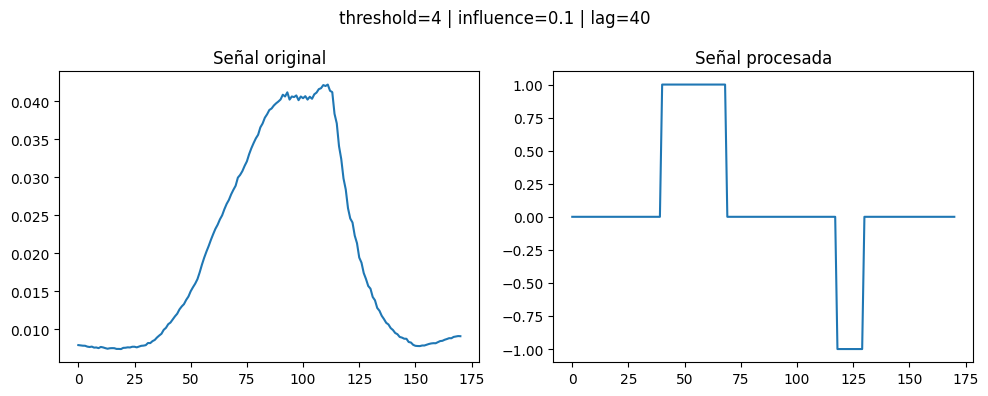

In [96]:
f = plt.figure(figsize=(10,4))
f.suptitle(f"threshold={threshold} | influence={influence} | lag={lag}")
ax = f.add_subplot(121)
ax.set_title('Señal original')
ax.plot(fms)
ax = f.add_subplot(122)
ax.set_title('Señal procesada')
ax.plot(fms2)
plt.tight_layout()
plt.show()

⭐**Conclusión**⭐

*Como conclusión final, no se pudo encontrar valores adecuados para representar la serie original. Se probaron muchos rangos pero ninguno fue satisfactorio. El que más se pareció fue el que se muestra en la figura anterior. Como segunda conculusión del algoritmo, cuanto más "lag" se le agregue, más se parece, pero esto no tiene mucho sentido ya que es como poner un umbral como los experimentos anteriores.*

<font color='MediumSeaGreen'>✔</font> *Mejoras posibles:* <font color='MediumSeaGreen'>✔</font>

<em>
1. Reducir o separar la función "do_experiment" para reducir su complejidad ciclomática de 32 a 15 aproximandamente.
2. Posiblemente, entrenar algún modelo en las series actuales para poder obtener un mejor detector de picos
</em>

## Referencias

- Brakel, J.P.G. van (2014). "Robust peak detection algorithm using z-scores". Stack Overflow. Available at: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362 (version: 2020-11-08).